In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [24]:
class Diff_Hist(nn.Module):
    def __init__(self, centers=[-5, -2.5, 0, 2.5, 5], scale=2):
        super(Diff_Hist, self).__init__()
        """ centers: center of the bins used. 
            scale  : exponential scale for sigmoid. the higher,
                the lower the amplitud of the bins.
        """
        # save params
        self.scale        = scale
        self.true_centers = centers
        self.max_scaler   = 1
        self.max_scaler   = torch.max(self.func(torch.arange(start=-1, end=1, step=1e-3)))
        # our function is centered @ 0.5 by default
        self.centers      = 0.5 + np.array(self.true_centers)

    def forward(self, x, batch=None, bsize=None):
        r""" reduces dim=0 as a set of bins. designed for 2d outs. """
        out = torch.zeros(len(self.centers), *x.shape[1:])
        for i, center in enumerate(self.centers):
            out[i]  = self.make_bin(x, center)
        return out / x.shape[0]

    def make_bin(self, x, center):
        return self.func(x+center).sum(dim=0, keepdim=True)
        
    def func(self, x):
        # augmenting sigmoid so higher gradient and localized feats
        sigmoid_x = lambda y: 1/(1+torch.exp(-self.scale*y))
        # perfrom minmax scaling so max is 1 and min (is already) 0
        return (sigmoid_x(x)-sigmoid_x(x-1))/self.max_scaler

    def __repr__(self):
        return "Simple differentiable histogram layer:" + \
               str({"centers"   : self.true_centers,
                    "exp_scale" : self.scale})

In [25]:
class Readout_Hist(nn.Module):
    def __init__(self, centers):
        super(Diff_Hist, self).__init__()
        # save centers
        self.true_centers = centers
        self.diff_hist    = Diff_Hist(centers=centers)

    def forward(self, x, batch=None, bsize=None, dim=0):
        r""" reduces dim=0 as a set of bins. designed for 2d outs. """
        bsize = bsize if bsize is not None else batch.shape[0]
        out   = torch.empty(bsize, len(self.centers), *x.shape[1:])
        # for all unique nodes
        for n in range(bsize):
            # create a multi-center hist for their feats
            out[n]  = self.diff_hist(x[batch==n])
        return out

    def __repr__(self):
        return "Readout by histogram:" + str({"centers": self.true_centers})

In [26]:
offset, n = 2, 5
centers = list(range(-offset*n, offset*n+1))
hister  = Diff_Hist(centers=centers)#[-8,-6,-4,-2,0,2,4,6,8])

(tensor([[7.9884e-08, 1.9495e-07, 7.1438e-08, 8.0497e-08, 1.0139e-07],
         [5.9026e-07, 1.4404e-06, 5.2786e-07, 5.9479e-07, 7.4921e-07],
         [4.3613e-06, 1.0642e-05, 3.9003e-06, 4.3949e-06, 5.5358e-06],
         [3.2216e-05, 7.8546e-05, 2.8817e-05, 3.2471e-05, 4.0896e-05],
         [2.3749e-04, 5.7567e-04, 2.1278e-04, 2.3974e-04, 3.0172e-04],
         [1.7255e-03, 4.0204e-03, 1.5641e-03, 1.7615e-03, 2.2047e-03],
         [1.1454e-02, 2.2355e-02, 1.1141e-02, 1.2501e-02, 1.5128e-02],
         [5.6847e-02, 8.8661e-02, 6.6523e-02, 7.2724e-02, 8.0136e-02],
         [2.0853e-01, 2.7156e-01, 2.4127e-01, 2.4236e-01, 2.5959e-01],
         [5.1186e-01, 5.1247e-01, 4.8791e-01, 4.8190e-01, 5.0347e-01],
         [6.6192e-01, 5.6227e-01, 6.1704e-01, 6.2103e-01, 6.1272e-01],
         [4.6052e-01, 3.9838e-01, 4.6362e-01, 4.7752e-01, 4.3775e-01],
         [1.9584e-01, 2.0867e-01, 2.0612e-01, 1.9897e-01, 1.9157e-01],
         [4.6624e-02, 7.3399e-02, 5.6985e-02, 4.6457e-02, 5.0776e-02],
      

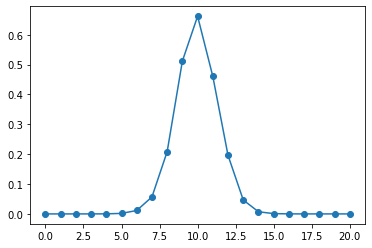

In [27]:
inputs = torch.randn(87,5)
# plot and print()
plt.plot(hister(inputs)[:, 0].flatten(), "o-")
hister(inputs), hister
